In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import batoid
import os
%matplotlib inline

In [2]:
HSCFile = os.path.join(batoid.datadir, 'HSC', 'HSC.yaml')
config = yaml.load(open(HSCFile))
telescope = batoid.parse.parse_optic(config['opticalSystem'])

In [3]:
def ku(thetaX, thetaY, nx):
    alpha, beta, gamma = batoid.utils.gnomicToDirCos(thetaX, thetaY)
    wavelength = 750e-9  # 750 nm
    # Create a ray grid with specified angle and grid number
    rays = batoid.rayGrid(
        telescope.dist, telescope.pupilSize, 
        alpha, beta, -gamma, 
        nx, wavelength, telescope.inMedium)

    # trace through the telescope
    tracedRays, outCoordsys = telescope.trace(rays)
    
    # The ray grid is created such that if propagated to time=0, 
    # it will coincide with the entrance pupil.  
    # So propagate the original rayGrid to t=0 so we can read off 
    # the pupil coordinates.
    batoid.propagatedToTimesMany(rays, [0]*len(rays))
    
    # Make plots!
    fig, axes = plt.subplots(ncols=2, figsize=(10, 4.5))
    axes[0].scatter(rays.x, tracedRays.kx, s=10)
    axes[0].set_xlabel("$u_x$ (meters)")
    axes[0].set_ylabel("$k_x$ (radians per meters)")

    axes[1].scatter(rays.y, tracedRays.ky, s=10)
    axes[1].set_xlabel("$u_y$ (meters)")
    axes[1].set_ylabel("$k_y$ (radians per meters)")
    
    fig.tight_layout()
    fig.show()
    return tracedRays

/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


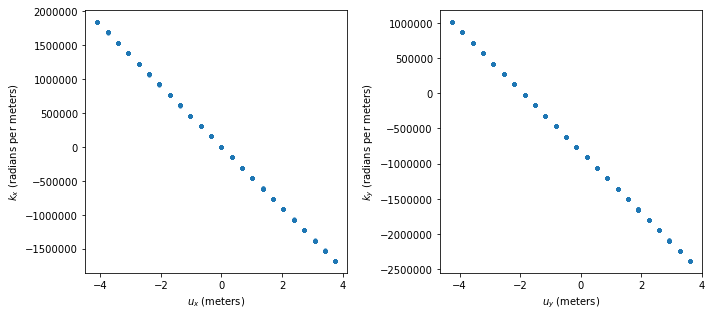

In [10]:
r = ku(0.000,0.01,24)

In [11]:
def dku(thetaX, thetaY, nx):
    alpha, beta, gamma = batoid.utils.gnomicToDirCos(thetaX, thetaY)
    wavelength = 750e-9  # 750 nm
    # Create a ray grid with specified angle and grid number
    rays = batoid.rayGrid(
        telescope.dist, telescope.pupilSize, 
        alpha, beta, -gamma, 
        nx, wavelength, telescope.inMedium)

    # trace through the telescope
    tracedRays, outCoordsys = telescope.trace(rays)
    
    # The ray grid is created such that if propagated to time=0, 
    # it will coincide with the entrance pupil.  
    # So propagate the original rayGrid to t=0 so we can read off 
    # the pupil coordinates.
    batoid.propagatedToTimesMany(rays, [0]*len(rays))

    # Trim vignetted rays from both rayVectors.
    good = np.where(1-tracedRays.isVignetted)[0]
    ux = rays.x[good]
    uy = rays.y[good]
    kx = tracedRays.kx[good]
    ky = tracedRays.ky[good]
    
    # Do a bilinear fit of kx and ky against ux and uy
    a = np.empty((len(ux), 3), dtype=float)
    a[:,0] = 1
    a[:,1] = ux
    a[:,2] = uy
    b = np.empty((len(ux), 2), dtype=float)
    b[:,0] = kx
    b[:,1] = ky
    soln, _, _, _ = np.linalg.lstsq(a, b, rcond=-1)

    predictKX = soln[0,0] + soln[1,0]*ux + soln[2,0]*uy
    predictKY = soln[0,1] + soln[1,1]*ux + soln[2,1]*uy
    
    # Make plots!
    fig, axes = plt.subplots(ncols=2, figsize=(10, 4.5))
    axes[0].scatter(ux, predictKX - kx, s=0.3, alpha=0.3)
    axes[0].set_xlabel("$u_x$ (meters)")
    axes[0].set_ylabel("$\Delta k_x$ (radians per meters)")

    axes[1].scatter(uy, predictKY - ky, s=0.3, alpha=0.3)
    axes[1].set_xlabel("$u_y$ (meters)")
    axes[1].set_ylabel("$\Delta k_y$ (radians per meters)")
    
    fig.tight_layout()
    fig.show()
    return soln

/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


array([[  7.57350243e-01,  -8.27735545e+05],
       [ -4.49226438e+05,   6.71984884e-02],
       [  2.12748603e-01,  -4.33114222e+05]])

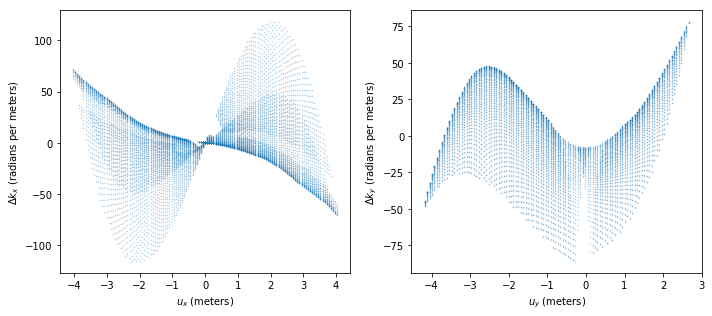

In [13]:
dku(0.00,0.01,128)

In [17]:
batoid.psf.dkdu(telescope, 0., 0.01, 750e-9)

array([[ -4.49226437e+05,   3.92539624e-01],
       [  1.33884884e-01,  -4.33114119e+05]])

In [18]:
# What is the pixel size in arcsec?
batoid.psf.dthdr(telescope, 0., 0.01, 750e-9) # radians per meter

array([[  5.36251801e-02,  -9.31086192e-07],
       [ -7.25378381e-08,   5.16997944e-02]])

In [19]:
# (spherical) arcsec per micron
thetaX = 0.0
thetaY = 0.01
print(batoid.utils.dSphericalDGnomic(thetaX, thetaY).dot(batoid.psf.dthdr(telescope, thetaX, thetaY, 750e-9)) * 206265 * 1e-6 * 15)
np.sqrt(np.linalg.det(batoid.utils.dSphericalDGnomic(thetaX, thetaY).dot(batoid.psf.dthdr(telescope, thetaX, thetaY, 750e-9)) * 206265 * 1e-6 * 15))

[[ -2.24407817e-07   1.59941877e-01]
 [ -1.65906671e-01   2.88061337e-06]]


0.1628969749611201

In [20]:
# tangent plane arcsec per micron
thetaX = 0.0
thetaY = 0.01
print(batoid.psf.dthdr(telescope, thetaX, thetaY, 750e-9) * 206265 * 1e-6 * 15)
np.sqrt(np.linalg.det(batoid.psf.dthdr(telescope, thetaX, thetaY, 750e-9) * 206265 * 1e-6 * 15))

[[  1.65914967e-01  -2.88075740e-06]
 [ -2.24430258e-07   1.59957871e-01]]


0.16290919208153262

In [21]:
np.zeros((2,2)).dtype

dtype('float64')